# Lab 3

Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

Problem description with live demo: [`https://tristanpenman.com/demos/n-puzzle/`](https://tristanpenman.com/demos/n-puzzle/)

## Importing library

In [59]:
from collections import deque
import sys
import os

from typing import Any, Deque

import numpy as np
from numpy.typing import NDArray

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import artist
import imageio.v2 as imageio

In [60]:
# Increase recursion limit for DFS and IDS
sys.setrecursionlimit(10000)

# Default initial and goal states
DEFAULT_INITIAL_STATE: NDArray = np.array(
    [
        [1, 2, 3],
        [4, 5, 6],
        [0, 7, 8],
    ]
)

DEFAULT_GOAL_STATE: NDArray = np.array(
    [
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 0],
    ]
)

In [61]:
def get_neighbors(state: NDArray[np.int32]) -> NDArray[np.int32]:
    neighbors: list[NDArray[np.int32]] = []
    x, y = np.argwhere(state == 0)[0]
    moves: list[tuple[int, int]] = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right
    for dx, dy in moves:
        nx, ny = x + dx, y + dy
        if 0 <= nx < state.shape[0] and 0 <= ny < state.shape[1]:
            new_state: NDArray[np.int32] = state.copy()
            new_state[x, y], new_state[nx, ny] = new_state[nx, ny], new_state[x, y]
            neighbors.append(new_state)
    return np.array(neighbors)


def search_util(
    current_state: NDArray[np.int32],
    goal_state: NDArray[np.int32],
    visited: set[bytes],
    path: list[NDArray[np.int32]],
    depth: int,
    max_depth: int,
):
    if depth > max_depth:
        return None
    if np.array_equal(current_state, goal_state):
        return path + [current_state]
    visited.add(current_state.tobytes())
    for neighbor in get_neighbors(current_state):
        if neighbor not in visited:
            result = search_util(neighbor, goal_state, visited, path + [current_state], depth + 1, max_depth)
            if result is not None:
                return result
    return None

## Solution Classes

### Breadth-First Search

In [62]:
class BFS:
    def __init__(
        self,
        initial_state: NDArray[np.int32] = DEFAULT_INITIAL_STATE,
        goal_state: NDArray[np.int32] = DEFAULT_GOAL_STATE,
    ) -> None:
        self.initial_state: NDArray[np.int32] = initial_state
        self.goal_state: NDArray[np.int32] = goal_state
        # The initial state is the first visited state
        self.visited: list[NDArray[np.int32]] = [initial_state]
        self.queue: Deque[tuple[NDArray, list]] = deque()

    def solve(self) -> list | None:
        self.queue.append((self.initial_state, []))

        while self.queue:
            current_state, path = self.queue.popleft()
            if np.array_equal(current_state, self.goal_state):
                print(f"BFS: Number of steps = {len(path)}")
                return path + [current_state]
            for neighbor in get_neighbors(current_state):
                # If the neighbor has not been visited before
                if not np.any([np.array_equal(neighbor, history) for history in self.visited]):
                    self.visited.append(neighbor)
                    self.queue.append((neighbor, path + [current_state]))
        print("BFS: No solution found")
        return None

### Depth First Search

In [63]:
class DFS:
    def __init__(self, initial_state=DEFAULT_INITIAL_STATE, goal_state=DEFAULT_GOAL_STATE) -> None:
        self.initial_state = initial_state
        self.goal_state = goal_state
        self.visited = set()
        self.path = []
        self.depth = 0
        self.max_depth = sys.getrecursionlimit()

    def solve(self):
        self.path = search_util(self.initial_state, self.goal_state, self.visited, [], self.depth, self.max_depth)
        if self.path is not None:
            print(f"DFS: Number of steps = {len(self.path) - 1}")
            return self.path
        else:
            print("DFS: No solution found")
            return None

## Iterative Deepening Search

In [64]:
class IDS:
    def __init__(self, initial_state=DEFAULT_INITIAL_STATE, goal_state=DEFAULT_GOAL_STATE):
        self.initial_state = initial_state
        self.goal_state = goal_state
        self.visited = set()
        self.path = []
        self.max_depth = 0

    def solve(self):
        while True:
            self.visited = set()
            self.path = search_util(self.initial_state, self.goal_state, self.visited, [], 0, self.max_depth)
            if self.path is not None:
                print(f"IDS: Number of steps = {len(self.path) - 1}")
                return self.path
            self.max_depth += 1
        print("IDS: No solution found")
        print("Anyway: How did you get here?")
        return None

## Utility

In [67]:
from typing import Collection, Sequence
from matplotlib.artist import Artist
from matplotlib.image import AxesImage


def save_solution_video(path: list[NDArray[np.int32]]) -> None:
    frames: Sequence[Collection[Artist]] = []
    N: int = path[0].shape[0]
    fig, ax = plt.subplots(figsize=(N, N))
    ax.axis('off')
    texts = [[ax.text(j, i, '', va='center', ha='center', fontsize=16, color='white') for j in range(N)] for i in range(N)]
    for state in path:
        img: AxesImage = ax.imshow(np.zeros((N, N)), cmap='gray', vmin=0, vmax=N * N - 1)
        for (i, j), val in np.ndenumerate(state):
            texts[i][j].set_text(str(val) if val != 0 else '')
        frames.append([img] + [text for row in texts for text in row])

    def get_frame(i):
        return frames[i]

    ani = animation.FuncAnimation(fig, get_frame, frames=len(frames), interval=2000, blit=True, repeat=True)
    # plt.show(fig)
    # To save the animation using Pillow as a gif
    writer = animation.PillowWriter(fps=1, bitrate=1800)
    ani.save('solution.gif', writer=writer)
    plt.close(fig)

def save_solution_video2(path: list[np.ndarray]) -> None:
    frames: Sequence[Collection[Artist]] = []
    N: int = path[0].shape[0]
    fig, ax = plt.subplots(figsize=(N, N))
    ax.axis('off')
    texts = [[ax.text(j, i, '', va='center', ha='center', fontsize=16, color='white') for j in range(N)] for i in range(N)]
    for state in path:
        img: AxesImage = ax.imshow(np.zeros((N, N)), cmap='gray', vmin=0, vmax=N * N - 1)
        for (i, j), val in np.ndenumerate(state):
            texts[i][j].set_text(str(val) if val != 0 else '')
        frames.append([img] + [text for row in texts for text in row])

    print(f"Total frames generated: {len(frames)}")

    def get_frame(i):
        return frames[i]

    ani = animation.FuncAnimation(fig, get_frame, frames=len(frames), interval=2000, blit=True, repeat=True)
    plt.show(fig)  # Uncomment this line to display the animation
    # To save the animation using Pillow as a gif
    writer = animation.PillowWriter(fps=1, bitrate=1800)
    ani.save('solution.gif', writer=writer)
    plt.close(fig)

# Running the Searches

BFS: Number of steps = 2
Total frames generated: 3


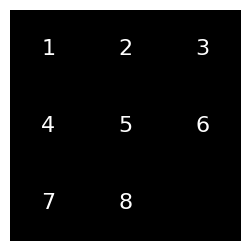

In [68]:
initial_state = DEFAULT_INITIAL_STATE
goal_state = DEFAULT_GOAL_STATE

# Solve using Breadth First Search
bfs_path = BFS(initial_state, goal_state).solve()
if bfs_path:
    save_solution_video2(bfs_path)

# # Solve using Deep First Search
# dfs_path = DFS(initial_state, goal_state).solve()
# if dfs_path:
#     visualize_solution(dfs_path)

# # Solve using Iterative Deepening Search
# ids_path = IDS(initial_state, goal_state).solve()
# if ids_path:
#     visualize_solution(ids_path)